In [ ]:
import sympy as sp

# --- Συμβολικά ---
E1, E2, A1, A2, I1, I2 = sp.symbols('E1 E2 A1 A2 I1 I2')
S, U = sp.symbols('S U')
N = sp.Symbol('N', positive=True)

# Παράμετροι
beta, p_dist, p_mask, em, na, k, p, l, ev = sp.symbols('beta p_dist p_mask em na k p l ev')
su, ga, gi, kl = sp.symbols('su ga gi kl')
f1 = sp.symbols('f1')

# --- Δύναμη μόλυνσης ---
force = (E1 + E2 + (1 - k)*na*(A1 + A2) + p*(I1 + I2))
scaling = beta * (1 - p_dist) * (1 - em * p_mask)
ls = scaling * force / N
lu = (1 - ev) * ls

# --- Νέες λοιμώξεις (F) ---
F = sp.Matrix([
    ls * S,
    lu * U,
    0,
    0,
    0,
    0
])

# --- Ροές μετάβασης (V) ---
V = sp.Matrix([
    su * E1,
    su * E2,
    - (1 - f1) * su * E1 + (ga + kl) * A1,
    - (1 - f1) * su * E2 + (ga + kl) * A2,
    - f1 * su * E1 + gi * I1 - kl * A1,
    - f1 * su * E2 + gi * I2 - kl * A2
])

# --- Πίνακες ---
infected_vars = [E1, E2, A1, A2, I1, I2]
F_matrix = F.jacobian(infected_vars)
V_matrix = V.jacobian(infected_vars)

print("\n--- F matrix ---")
sp.pprint(F_matrix)
print("\n--- V matrix ---")
sp.pprint(V_matrix)

# --- Υποκατάσταση τιμών (μοντέλο σου) ---
subs_vals = {
    beta: 0.6,
    p_dist: 0.6,
    p_mask: 0.65,
    em: 0.79,
    na: 0.752,
    k: 0.0011,
    p: 0.254,
    l: 0.926,
    ev: 0.75,
    su: 1/5.8,
    ga: 1/6,
    gi: 1/6,
    kl: 0.0011 * 0.926,
    f1: 0.844,
    N: 10370744
}

# --- Debug τιμών ---
print("\n--- DEBUG VALUES ---")
for key, val in subs_vals.items():
    print(f"{key} = {val}")

scaling_val = subs_vals[beta] * (1 - subs_vals[p_dist]) * (1 - subs_vals[em] * subs_vals[p_mask])
print(f"\nScaling factor (β*(1-dist)*(1-em*mask)) = {scaling_val}")

# --- Υπολογισμός R₀ ---
F_num = F_matrix.subs(subs_vals).evalf()
V_num = V_matrix.subs(subs_vals).evalf()
try:
    NGM = F_num * V_num.inv()
    eigenvals = list(NGM.eigenvals().keys())
    eigenval_values = [sp.re(ev.evalf()) for ev in eigenvals if ev.is_real]
    R0_val = max(eigenval_values) if eigenval_values else 0

    print("\n--- Next Generation Matrix (F·V⁻¹) ---")
    sp.pprint(NGM)

    print("\n--- Eigenvalues ---")
    for ev in eigenval_values:
        print(f"{ev}")

    print(f"\n✅ R₀ (maximum real eigenvalue): {R0_val}")

except Exception as e:
    print("\n⚠️ Error during matrix inversion or eigenvalue calculation:")
    print(e)


In [ ]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np


# --- Συμβολικά ---
E1, E2, A1, A2, I1, I2 = sp.symbols('E1 E2 A1 A2 I1 I2')
S, U = sp.symbols('S U')
N = sp.Symbol('N', positive=True)

beta, p_dist, p_mask, em, na, k, p, l, ev = sp.symbols('beta p_dist p_mask em na k p l ev')
su, ga, gi, kl = sp.symbols('su ga gi kl')
f1 = sp.symbols('f1')

# Δύναμη μόλυνσης
force = (E1 + E2 + (1 - k)*na*(A1 + A2) + p*(I1 + I2))
scaling = beta * (1 - p_dist) * (1 - em * p_mask)
ls = scaling * force / N
lu = (1 - ev) * ls

# F και V
F = sp.Matrix([
    ls * S,
    lu * U,
    0,
    0,
    0,
    0
])
V = sp.Matrix([
    su * E1,
    su * E2,
    - (1 - f1) * su * E1 + (ga + kl) * A1,
    - (1 - f1) * su * E2 + (ga + kl) * A2,
    - f1 * su * E1 + gi * I1 - kl * A1,
    - f1 * su * E2 + gi * I2 - kl * A2
])
infected_vars = [E1, E2, A1, A2, I1, I2]
F_matrix = F.jacobian(infected_vars)
V_matrix = V.jacobian(infected_vars)

# Σταθερές τιμές από το μοντέλο
base_vals = {
    beta: 0.6,
    p_dist: 0.6,
    em: 0.79,
    na: 0.752,
    k: 0.0011,
    p: 0.254,
    l: 0.926,
    ev: 0.75,
    su: 1/5.8,
    ga: 1/6,
    gi: 1/6,
    kl: 0.0011 * 0.926,
    f1: 0.844,
    N: 10370744
}

# --- Σάρωση p_mask ---
mask_range = [round(x, 2) for x in np.linspace(0, 1, 25)]
R0_values = []

for mask_val in mask_range:
    try:
        subs_vals = base_vals.copy()
        subs_vals[p_mask] = mask_val

        F_num = F_matrix.subs(subs_vals).evalf()
        V_num = V_matrix.subs(subs_vals).evalf()
        NGM = F_num * V_num.inv()
        eigenvals = list(NGM.eigenvals().keys())
        real_parts = [sp.re(ev.evalf()) for ev in eigenvals if ev.is_real]
        R0_val = max(real_parts) if real_parts else 0
        R0_values.append(R0_val)
    except Exception:
        R0_values.append(None)

# --- Γράφημα ---
plt.figure(figsize=(10, 5))
plt.plot(mask_range, R0_values, marker='o')
plt.xlabel("Ποσοστό χρήσης μάσκας (p_mask)")
plt.ylabel("R₀")
plt.title("Επίδραση της Χρήσης Μάσκας στον Αναπαραγωγικό Αριθμό R₀")
plt.axhline(y=1, color='gray', linestyle='--', label='Κατώφλι R₀=1')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from matplotlib.animation import FuncAnimation

# Πρώτα τρέχουμε το μοντέλο με τα βέλτιστα theta και κρατάμε τα αποτελέσματα
def solve_full(theta, t_all):
    def DifEq1(t, c):
        m = 1 / (82 * 365)
        L = 176
        em = 0.79
        na = 0.752
        l = 0.926
        ev = 0.75
        v = 0.0019
        psiu = 1 / 180
        sa = 1
        su = 1 / 5.8
        gaa = 1 / 6
        gi = 1 / 6
        gh = 1 / 18
        p = 0.254
        dh = 1 / 18
        sh = 1 / 4
        a = 0.17

        S, U, E1, E2, I1, I2, A1, A2, H1, R, D = c
        E = E1 + E2
        I = I1 + I2
        A = A1 + A2
        N = S + U + E + I + A + H1 + R

        ls = (theta[0] * (1 - theta[4]) * (1 - em * theta[3]) * (E + (1 - theta[1]) * na * A + p * I)) / \
             (N - ((1 - p) * I + theta[1] * A + H1 + ev * U))
        lu = (1 - ev) * ls

        dcdt = np.zeros(11)
        dcdt[0] = L - ls * S + psiu * U - v * S - m * S
        dcdt[1] = -lu * U - psiu * U + v * S - m * U
        dcdt[2] = ls * S - su * E1 - m * E1
        dcdt[3] = lu * U - su * E2 - m * E2
        dcdt[4] = theta[2] * su * E1 - theta[5] * sh * I1 - (1 - theta[5]) * gi * I1 + theta[1] * l * sa * A1 - m * I1
        dcdt[5] = theta[2] * su * E2 - (theta[5] / 10) * sh * I2 - (1 - theta[5] / 10) * gi * I2 + theta[1] * l * sa * A2 - m * I2
        dcdt[6] = (1 - theta[2]) * su * E1 - gaa * A1 - theta[1] * l * sa * A1 - m * A1
        dcdt[7] = (1 - theta[2]) * su * E2 - gaa * A2 - theta[1] * l * sa * A2 - m * A2
        dcdt[8] = theta[5] * sh * I1 + (theta[5] / 10) * sh * I2 - a * dh * H1 - (1 - a) * gh * H1 - m * H1
        dcdt[9] = (1 - theta[5]) * gi * I1 + (1 - theta[5]) * gi * I2 + gaa * A + (1 - a) * gh * H1 - m * R
        dcdt[10] = a * dh * H1
        return dcdt

    initial = [3318000, 6400000, 330000, 170000, 160000, 85000, 160000, 85000, 2800, 50000, 9500]
    sol = solve_ivp(DifEq1, [t_all[0], t_all[-1]], initial, t_eval=t_all, method='RK45')
    return sol

# Τρέξε το μοντέλο για όλη τη διάρκεια
t_anim = np.linspace(t[0], t[-1], 200)
solution = solve_full(theta_opt, t_anim)
S, E1, E2, I1, I2, D = solution.y[0], solution.y[2], solution.y[3], solution.y[4], solution.y[5], solution.y[10]
E = E1 + E2
I = I1 + I2

# --- Αnimation setup ---
fig, ax = plt.subplots()
line_s, = ax.plot([], [], label='S')
line_e, = ax.plot([], [], label='E')
line_i, = ax.plot([], [], label='I')
line_d, = ax.plot([], [], label='D')
ax.set_xlim(t_anim[0], t_anim[-1])
ax.set_ylim(0, max(E.max(), I.max(), D.max()) * 1.1) #S[0], 
ax.set_xlabel('Time (days)')
ax.set_ylabel('Population')
ax.set_title('COVID-19 Model Evolution')
ax.legend()
ax.grid(True)

def init():
    #line_s.set_data([], [])
    line_e.set_data([], [])
    line_i.set_data([], [])
    line_d.set_data([], [])
    return line_s, line_e, line_i, line_d

def update(frame):
    #line_s.set_data(t_anim[:frame], S[:frame])
    line_e.set_data(t_anim[:frame], E[:frame])
    line_i.set_data(t_anim[:frame], I[:frame])
    line_d.set_data(t_anim[:frame], D[:frame])
    return line_s, line_e, line_i, line_d

ani = FuncAnimation(fig, update, frames=len(t_anim), init_func=init, blit=True, interval=60)
# Αποθήκευση
import os
downloads_folder = os.path.join(os.path.expanduser("~"), "Downloads")
save_path = os.path.join(downloads_folder, "model_evolution.mp4")
ani.save(save_path, writer='ffmpeg', fps=20)
print(f"✔️ Το animation αποθηκεύτηκε στο: {save_path}")

plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.metrics import r2_score
import time
import os

# Load data from Excel
file_path = os.path.join(os.path.expanduser("~"), "Desktop", "mathematical_model_transmission_matlab", "transmission_model_matlab_codes", "FullEodyData.xlsx")
data = pd.read_excel(file_path)
t = data.iloc[670:731, 0].values  # time vector
c = data.iloc[670:731, 8].values  # cumulative deaths

# Initial conditions
initial = [3318000, 6400000, 330000, 170000, 160000, 85000, 160000, 85000, 2800, 50000, 9500]

# Store fitness and R² values per generation
fitness_history = []
r2_history = []

# Model function
def kinetics_ga(theta, t):
    def DifEq1(t, c):
        m = 1 / (82 * 365)
        L = 176
        em = 0.79
        na = 0.752
        l = 0.926
        ev = 0.75
        v = 0.0019
        psiu = 1 / 180
        sa = 1
        su = 1 / 5.8
        gaa = 1 / 6
        gi = 1 / 6
        gh = 1 / 18
        p = 0.254
        dh = 1 / 18
        sh = 1 / 4
        a = 0.17

        S, U, E1, E2, I1, I2, A1, A2, H1, R, D = c
        E = E1 + E2
        I = I1 + I2
        A = A1 + A2
        N = S + U + E + I + A + H1 + R

        ls = (theta[0] * (1 - theta[4]) * (1 - em * theta[3]) * (E + (1 - theta[1]) * na * A + p * I)) / \
             (N - ((1 - p) * I + theta[1] * A + H1 + ev * U))
        lu = (1 - ev) * ls

        dcdt = np.zeros(11)
        dcdt[0] = L - ls * S + psiu * U - v * S - m * S
        dcdt[1] = -lu * U - psiu * U + v * S - m * U
        dcdt[2] = ls * S - su * E1 - m * E1
        dcdt[3] = lu * U - su * E2 - m * E2
        dcdt[4] = theta[2] * su * E1 - theta[5] * sh * I1 - (1 - theta[5]) * gi * I1 + theta[1] * l * sa * A1 - m * I1
        dcdt[5] = theta[2] * su * E2 - (theta[5] / 10) * sh * I2 - (1 - theta[5] / 10) * gi * I2 + theta[1] * l * sa * A2 - m * I2
        dcdt[6] = (1 - theta[2]) * su * E1 - gaa * A1 - theta[1] * l * sa * A1 - m * A1
        dcdt[7] = (1 - theta[2]) * su * E2 - gaa * A2 - theta[1] * l * sa * A2 - m * A2
        dcdt[8] = theta[5] * sh * I1 + (theta[5] / 10) * sh * I2 - a * dh * H1 - (1 - a) * gh * H1 - m * H1
        dcdt[9] = (1 - theta[5]) * gi * I1 + (1 - theta[5]) * gi * I2 + gaa * A + (1 - a) * gh * H1 - m * R
        dcdt[10] = a * dh * H1

        return dcdt

    sol = solve_ivp(DifEq1, [t[0], t[-1]], initial, t_eval=t, method='RK45')
    return sol.y[10]  # D (deaths)

# Objective function
def objective(theta):
    C = kinetics_ga(theta, t)
    fitness = np.linalg.norm(c - C)
    r2 = r2_score(c, C)
    fitness_history.append(fitness)
    r2_history.append(r2)
    return fitness

# Optimization
bounds = [(0, 1.5), (0, 1), (0.3, 0.8), (0.3, 1), (0.3, 1), (0, 0.1)]
pop_size = 50
max_gen = 50

print("\nStart Time:", time.strftime("%Y-%m-%d %H:%M:%S"))
result = differential_evolution(objective, bounds, strategy='best1bin', popsize=pop_size // len(bounds), maxiter=max_gen)
print("\nStop Time:", time.strftime("%Y-%m-%d %H:%M:%S"))
print("\nRate Constants:")
for i, val in enumerate(result.x):
    print(f"\tTheta({i+1}) = {val:.5f}")

# Save results
np.save("theta.npy", result.x)

# Plot fit
tv = np.linspace(min(t), max(t), 300)
Cfit = kinetics_ga(result.x, tv)

plt.figure()
plt.plot(t, c, 'pr', label='Real data')
plt.plot(tv, Cfit, 'b', label='Fitted curve')
plt.xlabel('Time (days)')
plt.ylabel('Deceased Individuals')
plt.legend()
plt.grid(True)
plt.title('Model Fit')
plt.show()

# Animation of fitness and R²
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
points1 = ax1.plot([], [], 'ro', label='Fitness Value')[0]
points2 = ax2.plot([], [], 'bo', label='R² Score')[0]
text_fitness = ax1.text(0.02, 0.9, '', transform=ax1.transAxes, color='red', fontsize=10)
text_r2 = ax2.text(0.02, 0.85, '', transform=ax2.transAxes, color='blue', fontsize=10)

ax1.set_xlim(0, len(fitness_history))
ax1.set_ylim(0, max(fitness_history) * 1.1)
ax2.set_ylim(0, 1)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness Value", color='r')
ax2.set_ylabel("R² Score", color='b')
ax1.set_title("GA Evolution: Fitness & R²")
ax1.grid(True)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

# Display final best values
best_fitness = min(fitness_history)
best_r2 = max(r2_history)
best_fit_text = ax1.text(0.5, 0.15, f"Best Fitness: {best_fitness:.2f}", transform=ax1.transAxes, 
                         ha='center', va='center', fontsize=10, color='red')
best_r2_text = ax2.text(0.5, 0.1, f"Best R²: {best_r2:.3f}", transform=ax2.transAxes, 
                         ha='center', va='center', fontsize=10, color='blue')

def init():
    points1.set_data([], [])
    points2.set_data([], [])
    text_fitness.set_text('')
    text_r2.set_text('')
    return points1, points2, text_fitness, text_r2, best_fit_text, best_r2_text

def update(frame):
    x = np.arange(frame + 1)
    y1 = fitness_history[:frame + 1]
    y2 = r2_history[:frame + 1]
    points1.set_data(x, y1)
    points2.set_data(x, y2)
    text_fitness.set_text(f'Fitness: {y1[-1]:.2f}')
    text_r2.set_text(f'R²: {y2[-1]:.3f}')
    return points1, points2, text_fitness, text_r2, best_fit_text, best_r2_text

ani = FuncAnimation(fig, update, frames=len(fitness_history), init_func=init, blit=True, interval=100)

save_path = os.path.join(os.path.expanduser("~"), "Downloads", "ga_fit_r2_animation.mp4")
ani.save(save_path, writer='ffmpeg', fps=10)
plt.close()

print(f"✅ Το animation αποθηκεύτηκε στο: {save_path}")


In [ ]:
import numpy as np
import sympy as sp

# Δώσε τις τιμές του theta
theta = [0.7, 0.8, 0.5, 0.6, 0.7, 0.03]  # π.χ. από το αποτέλεσμα του GA

# Σταθερές μοντέλου
na = 0.752
p = 0.254
ev = 0.75
em = 0.79
l = 0.926
sa = 1
su = 1 / 5.8
gaa = 1 / 6
gi = 1 / 6
sh = 1 / 4

# Δημιουργία συμβολικών μεταβλητών για τις κλάσεις
E1, E2, I1, I2, A1, A2 = sp.symbols("E1 E2 I1 I2 A1 A2")
state = sp.Matrix([E1, E2, I1, I2, A1, A2])

# Πίνακας F (νέες λοιμώξεις)
F = sp.Matrix([
    [theta[0] * (1 - theta[4]) * (1 - em * theta[3]), 0, theta[0]*(1 - theta[4])*(1 - em*theta[3])*p, 0, theta[0]*(1 - theta[4])*(1 - em*theta[3])*(1 - theta[1])*na, 0],
    [0, theta[0]*(1 - theta[4])*(1 - em*theta[3])*(1 - ev), 0, theta[0]*(1 - theta[4])*(1 - em*theta[3])*(1 - ev)*p, 0, theta[0]*(1 - theta[4])*(1 - em*theta[3])*(1 - ev)*(1 - theta[1])*na],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
])

# Πίνακας V (μεταβάσεις)
V = sp.Matrix([
    [su, 0, 0, 0, 0, 0],
    [0, su, 0, 0, 0, 0],
    [-theta[2]*su, 0, theta[5]*sh + (1 - theta[5])*gi, 0, -theta[1]*l*sa, 0],
    [0, -theta[2]*su, 0, (theta[5]/10)*sh + (1 - theta[5]/10)*gi, 0, -theta[1]*l*sa],
    [-(1 - theta[2])*su, 0, 0, 0, gaa + theta[1]*l*sa, 0],
    [0, -(1 - theta[2])*su, 0, 0, 0, gaa + theta[1]*l*sa]
])

# Υπολογισμός NGM και R0
NGM = F * V.inv()
eigenvals = NGM.eigenvals()
R0_val = max(eigenvals, key=lambda x: sp.re(x))

# Εκτύπωση
print("\nΠίνακας F (νέες λοιμώξεις):")
sp.pprint(F)

print("\nΠίνακας V (μεταβάσεις):")
sp.pprint(V)

print("\nΠίνακας NGM (F * V⁻¹):")
sp.pprint(NGM)

print("\nR₀ =", R0_val.evalf())


In [ ]:
import sympy as sp

# Ορισμός συμβολικών παραμέτρων
beta, p_dist, eps_mask, p_mask = sp.symbols('beta p_dist eps_mask p_mask')
k, n_a, p, eps_vac = sp.symbols('k n_a p eps_vac')
mu, sigma_u = sp.symbols('mu sigma_u')
gamma_a, l, sigma_alpha = sp.symbols('gamma_a l sigma_alpha')
f1, f2, f2p = sp.symbols('f1 f2 f2p')
gamma_i, sigma_h = sp.symbols('gamma_i sigma_h')

# Μέσοι χρόνοι
V11 = 1 / (mu + sigma_u)
V33 = 1 / (gamma_a + k * l * sigma_alpha + mu)
V55 = 1 / (f2 * sigma_h + (1 - f2) * gamma_i + mu)
V22 = V11
V44 = V33
V66 = 1 / (f2p * sigma_h + (1 - f2p) * gamma_i + mu)

# Συντελεστής μετάδοσης
C = beta * (1 - p_dist) * (1 - eps_mask * p_mask)

# Πίνακας K (2x3)
K = sp.Matrix([
    [C * V11, C * (1 - k) * n_a * V33, C * p * V55],
    [C * (1 - eps_vac) * V22,
     C * (1 - eps_vac) * (1 - k) * n_a * V44,
     C * (1 - eps_vac) * p * V66]
])

# K * K^T
Ksq = K * K.T

# Εμφάνιση πίνακα
print("K · Kᵀ:")
sp.pprint(Ksq)

# Ορισμός συμβολικής μέγιστης ιδιοτιμής
l1, l2 = sp.symbols('lambda_1 lambda_2')
sp.init_printing()

print("\nR₀ = sqrt(max(lambda)) (λογικά μία από τις ιδιοτιμές του παρακάτω πίνακα):")
sp.pprint(sp.sqrt(sp.Symbol("lambda_max")))


In [ ]:
import sympy as sp

# Ορισμός συμβολικών παραμέτρων
beta, p_dist, eps_mask, p_mask = sp.symbols('beta p_dist eps_mask p_mask')
k, n_a, p, eps_vac = sp.symbols('k n_a p eps_vac')
mu, sigma_u = sp.symbols('mu sigma_u')
gamma_a, l, sigma_alpha = sp.symbols('gamma_a l sigma_alpha')
f1, f2, f2p = sp.symbols('f1 f2 f2p')
gamma_i, sigma_h = sp.symbols('gamma_i sigma_h')

# Μέσοι χρόνοι παραμονής
V11 = 1 / (mu + sigma_u)
V22 = V11
V33 = 1 / (gamma_a + k * l * sigma_alpha + mu)
V44 = V33
V55 = 1 / (f2 * sigma_h + (1 - f2) * gamma_i + mu)
V66 = 1 / (f2p * sigma_h + (1 - f2p) * gamma_i + mu)

# Συντελεστής μετάδοσης
C = beta * (1 - p_dist) * (1 - eps_mask * p_mask)

# Πίνακας K (2x3) με μη μηδενικά στοιχεία
K = sp.Matrix([
    [C * V11, C * (1 - k) * n_a * V33, C * p * V55],
    [C * (1 - eps_vac) * V22,
     C * (1 - eps_vac) * (1 - k) * n_a * V44,
     C * (1 - eps_vac) * p * V66]
])

# Πίνακας K * Kᵀ
K_sq = K * K.T

# Στοιχεία πίνακα K_sq
a = K_sq[0, 0]
b = K_sq[0, 1]  # και [1, 0]
d = K_sq[1, 1]

# Τύπος φασματικής ακτίνας
R0 = sp.sqrt((a + d)/2 + sp.sqrt((a - d)**2 + 4*b**2)/2)

# Εκτύπωση αποτελέσματος
sp.init_printing()
print("Τύπος R₀ συμβολικά:")
sp.pprint(R0)


In [ ]:
import sympy as sp

# Συμβολικοί ορισμοί
beta, p_dist, eps_mask, p_mask = sp.symbols('beta p_dist eps_mask p_mask')
k, n_a, p, eps_vac = sp.symbols('k n_a p eps_vac')
mu, sigma_u = sp.symbols('mu sigma_u')
gamma_a, l, sigma_alpha = sp.symbols('gamma_a l sigma_alpha')
f1, f2, f2p = sp.symbols('f1 f2 f2p')
gamma_i, sigma_h = sp.symbols('gamma_i sigma_h')

# Μέσοι χρόνοι παραμονής σε καταστάσεις
V11 = 1 / (mu + sigma_u)
V22 = V11
V33 = 1 / (gamma_a + k * l * sigma_alpha + mu)
V44 = V33
V55 = 1 / (f2 * sigma_h + (1 - f2) * gamma_i + mu)
V66 = 1 / (f2p * sigma_h + (1 - f2p) * gamma_i + mu)

# Κοινός συντελεστής
C = beta * (1 - p_dist) * (1 - eps_mask * p_mask)

# Πίνακας K (2x3 με μη μηδενικά στοιχεία)
K = sp.Matrix([
    [C * V11, C * (1 - k) * n_a * V33, C * p * V55],
    [C * (1 - eps_vac) * V22,
     C * (1 - eps_vac) * (1 - k) * n_a * V44,
     C * (1 - eps_vac) * p * V66]
])

# Υπολογισμός τετράγωνου πίνακα K·Kᵀ
K_sq = K * K.T

# Υπολογισμός χαρακτηριστικού πολυωνύμου και φασματικής ακτίνας
eigvals = K_sq.eigenvals()
rho = sp.sqrt(sp.Max(*eigvals.keys()))

# Εκτύπωση
sp.pprint(K_sq)
print("\nR₀ = sqrt(μέγιστη ιδιοτιμή του K·Kᵀ):")
sp.pprint(rho)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Βασικές σταθερές
p_dist = 0.62
eps_mask = 0.8
p_mask = 0.45
k = 0.1726
n_a = 0.75
p = 0.25
eps_vac = 0.75

# Μέσοι χρόνοι παραμονής (από V^-1)
V11 = 1 / (0.01 + 1/5.8)
V22 = V11
V33 = 1 / (1/6 + k * 0.926 * 1)  # A1
V44 = V33
V55 = 1 / (0.057 * 1/4 + (1 - 0.057) * 1/6 + 0.01)  # Id1
V66 = 1 / (0.085 * 1/4 + (1 - 0.085) * 1/6 + 0.01)  # Id2

# Sweep over beta
beta_range = np.linspace(0.1, 1.5, 100)
R0_values = []

for beta in beta_range:
    C = beta * (1 - p_dist) * (1 - eps_mask * p_mask)

    # K reduced terms
    K11 = C * V11
    K12 = C * (1 - k) * n_a * V33
    K13 = C * p * V55
    K21 = C * (1 - eps_vac) * V22
    K22 = C * (1 - eps_vac) * (1 - k) * n_a * V44
    K23 = C * (1 - eps_vac) * p * V66

    # Compute a, d, b
    a = K11**2 + K12**2 + K13**2
    d = K21**2 + K22**2 + K23**2
    b = K11*K21 + K12*K22 + K13*K23

    R0 = np.sqrt((a + d)/2 + 0.5 * np.sqrt((a - d)**2 + 4*b**2))
    R0_values.append(R0)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(beta_range, R0_values, color='darkblue')
plt.xlabel("β (βασικός ρυθμός επαφών)")
plt.ylabel("R₀")
plt.title("R₀ σε συνάρτηση του β")
plt.grid(True)
plt.tight_layout()
plt.show()


Έτοιμο!


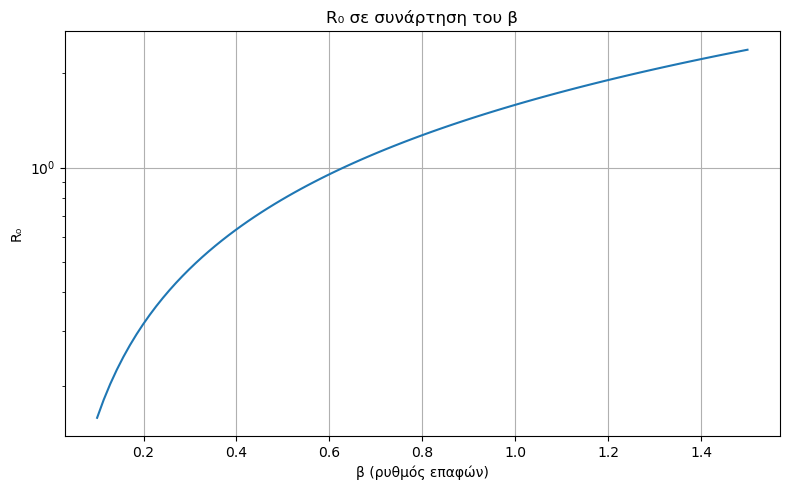

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# === ΟΡΙΣΕ ΕΔΩ ΟΛΕΣ ΤΙΣ ΤΙΜΕΣ ===
N = 10370744
Λ = 176
v = 2e-4
sigma_alpha = 1
mu = 1 / (82 * 365)
emask = 0.79
n_a = 0.76
a = 0.17
psi_u = 1 / 160  # μέση τιμή μεταξύ 140 και 180

eps_vac = 0.75
sigma_u = 1 / 5.8
sigma_h = 1 / 4
gamma_a = 1 / 6
gamma_i = 1 / 6
gamma_h = 1 / 12
delta_h = 1 / 18

# Ευαισθησία self-test
l = 0.926

# Παράμετροι συμπεριφοράς
p_dist = 0.62
eps_mask = emask
p_mask = 0.45
k = 0.1726
p = 0.25

# Νοσοκομειακή μεταβλητότητα
f2 = 0.057
f2p = f2/10
kl = k * l

# Μέσοι χρόνοι παραμονής (από V^-1)
V11 = 1 / (mu + sigma_u)
V22 = V11
V33 = 1 / (gamma_a + kl * sigma_alpha + mu)
V44 = V33
V55 = 1 / (f2 * sigma_h + (1 - f2) * gamma_i + mu)
V66 = 1 / (f2p * sigma_h + (1 - f2p) * gamma_i + mu)

# Sweep της παραμέτρου που θες (π.χ. β)
beta_range = np.linspace(0.1, 1.5, 100)
R0_values = []

for beta in beta_range:
    C = beta * (1 - p_dist) * (1 - eps_mask * p_mask)

    # Πίνακας K reduced (2x3)
    K11 = C * V11
    K12 = C * (1 - k) * n_a * V33
    K13 = C * p * V55

    K21 = C * (1 - eps_vac) * V22
    K22 = C * (1 - eps_vac) * (1 - k) * n_a * V44
    K23 = C * (1 - eps_vac) * p * V66

    # Υπολογισμός R₀
    a_val = K11**2 + K12**2 + K13**2
    d_val = K21**2 + K22**2 + K23**2
    b_val = K11*K21 + K12*K22 + K13*K23

    R0 = np.sqrt((a_val + d_val)/2 + 0.5 * np.sqrt((a_val - d_val)**2 + 4*b_val**2))
    R0_values.append(R0)

# Γράφημα
plt.figure(figsize=(8, 5))
plt.semilogy(beta_range, R0_values)

#plt.plot(beta_range, R0_values, color='darkblue')
plt.xlabel("β (ρυθμός επαφών)")
plt.ylabel("R₀")
plt.title("R₀ σε συνάρτηση του β")
plt.grid(True)
plt.tight_layout()
plt.show()


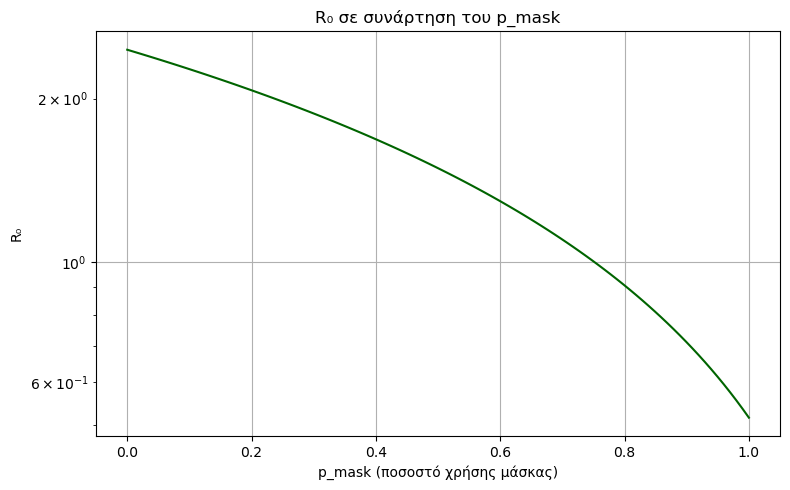

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# === ΣΤΑΘΕΡΕΣ ΤΙΜΕΣ ===
p_dist = 0.62
eps_mask = 0.79
k = 0.1726
n_a = 0.76
p = 0.25
eps_vac = 0.75
l = 0.926
sigma_alpha = 1
mu = 1 / (82 * 365)
sigma_u = 1 / 5.8
sigma_h = 1 / 4
gamma_a = 1 / 6
gamma_i = 1 / 6
gamma_h = 1 / 12
delta_h = 1 / 18
f2 = 0.057
f2p = f2
kl = k * l

# Μέσοι χρόνοι παραμονής (από V^-1)
V11 = 1 / (mu + sigma_u)
V22 = V11
V33 = 1 / (gamma_a + kl * sigma_alpha + mu)
V44 = V33
V55 = 1 / (f2 * sigma_h + (1 - f2) * gamma_i + mu)
V66 = 1 / (f2p * sigma_h + (1 - f2p) * gamma_i + mu)

# Sweep της παραμέτρου p_mask
p_mask_range = np.linspace(0, 1, 100)
R0_values = []
beta = 1.0  # σταθερό β για να απομονώσουμε την επίδραση του p_mask

for p_mask in p_mask_range:
    C = beta * (1 - p_dist) * (1 - eps_mask * p_mask)

    K11 = C * V11
    K12 = C * (1 - k) * n_a * V33
    K13 = C * p * V55

    K21 = C * (1 - eps_vac) * V22
    K22 = C * (1 - eps_vac) * (1 - k) * n_a * V44
    K23 = C * (1 - eps_vac) * p * V66

    a_val = K11**2 + K12**2 + K13**2
    d_val = K21**2 + K22**2 + K23**2
    b_val = K11*K21 + K12*K22 + K13*K23

    R0 = np.sqrt((a_val + d_val)/2 + 0.5 * np.sqrt((a_val - d_val)**2 + 4*b_val**2))
    R0_values.append(R0)

# Γράφημα
plt.figure(figsize=(8, 5))
plt.semilogy(p_mask_range, R0_values, color='darkgreen')

#plt.plot(p_mask_range, R0_values, color='darkgreen')
plt.xlabel("p_mask (ποσοστό χρήσης μάσκας)")
plt.ylabel("log(R₀)")
plt.title("R₀ σε συνάρτηση του p_mask")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/rf/mrtbxhpn4tqdglcfpw6yhb4w0000gn/T/ipykernel_71012/1320160928.py:70: RuntimeWarning: divide by zero encountered in log
  ax1.plot(x, np.log(results["p_dist"]), 'indianred', label="log(R₀) vs p_dist")


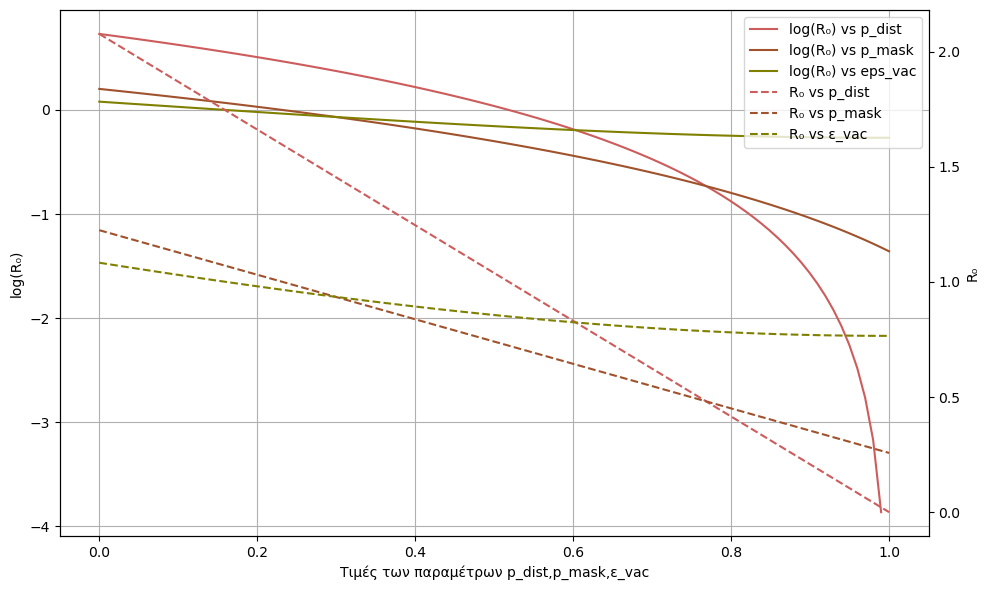

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# --- Ορισμός παραμέτρων (όπως πριν) ---
mu = 1 / (82 * 365)
sigma_u = 1 / 5.8
gamma_a = 1 / 6
gamma_i = 1 / 6
sigma_h = 1 / 4
l = 0.93
sigma_alpha = 1
k = 0.1726 #k=0.69 omikron
p = 0.25
n_a = 0.76
emask = 0.79
f2 = 0.038
f2p = f2/10
kl = k * l

# V^-1 terms
V11 = 1 / (mu + sigma_u)
V22 = V11
V33 = 1 / (gamma_a + kl * sigma_alpha + mu)
V44 = V33
V55 = 1 / (f2 * sigma_h + (1 - f2) * gamma_i + mu)
V66 = 1 / (f2p * sigma_h + (1 - f2p) * gamma_i + mu)

# --- Sweep values ---
x = np.linspace(0, 1, 100)
beta = 0.4974

# --- Αποτελέσματα για κάθε μεταβλητή ---
results = {}

for var_name in ["p_dist", "p_mask", "eps_vac"]:
    R0_list = []

    for val in x:
        # Σταθερές τιμές για κάθε παράμετρο
        p_dist = val if var_name == "p_dist" else 0.62
        p_mask = val if var_name == "p_mask" else 0.45
        eps_vac = val if var_name == "eps_vac" else 0.75

        C = beta * (1 - p_dist) * (1 - emask * p_mask)

        # Πίνακας K
        K11 = C * V11
        K12 = C * (1 - k) * n_a * V33
        K13 = C * p * V55

        K21 = C * (1 - eps_vac) * V22
        K22 = C * (1 - eps_vac) * (1 - k) * n_a * V44
        K23 = C * (1 - eps_vac) * p * V66

        a = K11**2 + K12**2 + K13**2
        d = K21**2 + K22**2 + K23**2
        b = K11*K21 + K12*K22 + K13*K23

        R0 = np.sqrt((a + d)/2 + 0.5 * np.sqrt((a - d)**2 + 4*b**2))
        R0_list.append(R0)

    results[var_name] = np.array(R0_list)

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()

# Λογαριθμική καμπύλη (αριστερός άξονας)
ax1.plot(x, np.log(results["p_dist"]), 'indianred', label="log(R₀) vs p_dist")
ax1.plot(x, np.log(results["p_mask"]), 'sienna', label="log(R₀) vs p_mask")
ax1.plot(x, np.log(results["eps_vac"]), 'olive', label="log(R₀) vs eps_vac")
ax1.set_ylabel("log(R₀)")
ax1.set_xlabel("Τιμές των παραμέτρων p_dist,p_mask,ε_vac")
ax1.grid(True)

# Κανονική καμπύλη (δεξιός άξονας)
ax2.plot(x, results["p_dist"], color='indianred', linestyle="--",label="R₀ vs p_dist")
ax2.plot(x, results["p_mask"], color='sienna', linestyle="--",label="R₀ vs p_mask")
ax2.plot(x, results["eps_vac"], color='olive',linestyle="--", label="R₀ vs ε_vac")
ax2.set_ylabel("R₀")

# Συνδυασμένος υπότιτλος
#plt.title("R₀ και log(R₀) σε συνάρτηση p_dist, p_mask, ε_vac")

# Συνδυαστικός legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.tight_layout()
import os
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "phd", f"R0.png")
plt.savefig(desktop_path, bbox_inches='tight')

plt.show()


In [13]:
import numpy as np

# --- Ορισμός βασικών σταθερών (όπως πριν) ---
mu = 1 / (82 * 365)
sigma_u = 1 / 5.8
gamma_a = 1 / 6
gamma_i = 1 / 6
sigma_h = 1 / 4
l = 0.926
sigma_alpha = 1
k = 0.1726
p = 0.25
n_a = 0.76
emask = 0.79
f2 = 0.057
f2p = f2/10
kl = k * l

# Βασικές τιμές
p_mask_base = 0.45
p_dist_base = 0.62
eps_vac_base = 0.75
beta = 0.4974

# V^-1 όροι
V11 = 1 / (mu + sigma_u)
V22 = V11
V33 = 1 / (gamma_a + kl * sigma_alpha + mu)
V44 = V33
V55 = 1 / (f2 * sigma_h + (1 - f2) * gamma_i + mu)
V66 = 1 / (f2p * sigma_h + (1 - f2p) * gamma_i + mu)

# Συνάρτηση R0
def compute_R0(p_dist, p_mask, eps_vac):
    C = beta * (1 - p_dist) * (1 - emask * p_mask)

    K11 = C * V11
    K12 = C * (1 - k) * n_a * V33
    K13 = C * p * V55

    K21 = C * (1 - eps_vac) * V22
    K22 = C * (1 - eps_vac) * (1 - k) * n_a * V44
    K23 = C * (1 - eps_vac) * p * V66

    a = K11**2 + K12**2 + K13**2
    d = K21**2 + K22**2 + K23**2
    b = K11*K21 + K12*K22 + K13*K23

    return np.sqrt((a + d)/2 + 0.5 * np.sqrt((a - d)**2 + 4*b**2))

# Αναζήτηση thresholds
x = np.linspace(0, 1, 500)

thresholds = {}

for var in ["p_dist", "p_mask", "eps_vac"]:
    for val in x:
        if var == "p_dist":
            r0 = compute_R0(val, p_mask_base, eps_vac_base)
        elif var == "p_mask":
            r0 = compute_R0(p_dist_base, val, eps_vac_base)
        elif var == "eps_vac":
            r0 = compute_R0(p_dist_base, p_mask_base, val)
        
        if r0 < 1:
            thresholds[var] = val
            break
    else:
        thresholds[var] = None

print("🧮 Κατώφλια για R₀ < 1:")
for var, val in thresholds.items():
    if val is not None:
        print(f" - {var} πρέπει να είναι τουλάχιστον {val:.3f}")
    else:
        print(f" - {var} δεν μπορεί να φέρει το R₀ κάτω από 1 μόνο του.")


🧮 Κατώφλια για R₀ < 1:
 - p_dist πρέπει να είναι τουλάχιστον 0.519
 - p_mask πρέπει να είναι τουλάχιστον 0.232
 - eps_vac πρέπει να είναι τουλάχιστον 0.160


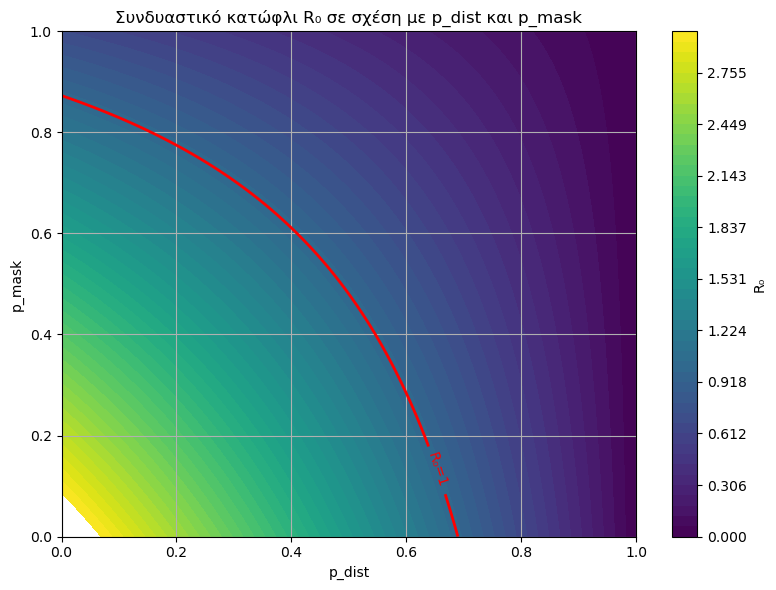

In [15]:
import matplotlib.pyplot as plt

# Δημιουργία πλέγματος
p_dist_vals = np.linspace(0, 1, 100)
p_mask_vals = np.linspace(0, 1, 100)

P_dist, P_mask = np.meshgrid(p_dist_vals, p_mask_vals)
R0_grid = np.zeros_like(P_dist)

for i in range(P_dist.shape[0]):
    for j in range(P_dist.shape[1]):
        R0_grid[i, j] = compute_R0(P_dist[i, j], P_mask[i, j], eps_vac_base)

# Γράφημα
plt.figure(figsize=(8,6))
cp = plt.contourf(P_dist, P_mask, R0_grid, levels=np.linspace(0, 3, 50), cmap='viridis')
plt.colorbar(cp, label='R₀')

# Γραμμή R₀ = 1
cs = plt.contour(P_dist, P_mask, R0_grid, levels=[1], colors='red', linewidths=2)
plt.clabel(cs, fmt="R₀=1", colors='red')

plt.xlabel("p_dist")
plt.ylabel("p_mask")
plt.title("Συνδυαστικό κατώφλι R₀ σε σχέση με p_dist και p_mask")
plt.grid(True)
plt.tight_layout()
plt.show()
